# Etapa 3: Modelagem Preditiva - Parte 2
## Modelos de Machine Learning

Neste notebook implementaremos:
- Prophet (Facebook Prophet)
- LSTM (Long Short-Term Memory Networks)
- Regressão com Features Temporais
- XGBoost para Séries Temporais

In [1]:
# Instalação de bibliotecas
#!pip install prophet xgboost tensorflow keras scikit-learn --break-system-packages -q

In [2]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Prophet
from prophet import Prophet

# Machine Learning
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Bibliotecas importadas com sucesso!")
print(f"TensorFlow version: {tf.__version__}")

2025-11-23 19:58:17.019975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-23 19:58:17.299097: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


✓ Bibliotecas importadas com sucesso!
TensorFlow version: 2.10.0


In [3]:
# Carregar dados
train_data = pd.read_csv('train_data.csv', parse_dates=['Date'])
val_data = pd.read_csv('val_data.csv', parse_dates=['Date'])
test_data = pd.read_csv('test_data.csv', parse_dates=['Date'])

print(f"Train: {len(train_data)} registros")
print(f"Validation: {len(val_data)} registros")
print(f"Test: {len(test_data)} registros")

# Carregar resultados anteriores
import pickle
with open('baseline_statistical_results.pkl', 'rb') as f:
    previous_results = pickle.load(f)

results = {}

Train: 2979 registros
Validation: 990 registros
Test: 981 registros


## Funções Auxiliares

In [4]:
def calculate_metrics(y_true, y_pred, model_name="Model"):
    """Calcula métricas de avaliação"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    r2 = r2_score(y_true, y_pred)
    
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    }

def plot_predictions(y_true, y_pred, dates, title, train_data=None):
    """Plota previsões vs valores reais"""
    plt.figure(figsize=(15, 5))
    
    if train_data is not None:
        plt.plot(train_data['Date'], train_data['Views'], 
                label='Treino', alpha=0.5, linewidth=1)
    
    plt.plot(dates, y_true, label='Real', marker='o', linewidth=2)
    plt.plot(dates, y_pred, label='Predição', marker='s', linewidth=2, linestyle='--')
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Visualizações', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("✓ Funções auxiliares definidas")

✓ Funções auxiliares definidas


## 1. Prophet (Facebook Prophet)

19:58:20 - cmdstanpy - INFO - Chain [1] start processing


PROPHET (FACEBOOK PROPHET)

Processando: 2NE1_zh.wikipedia.org_all-access_spider...


19:58:20 - cmdstanpy - INFO - Chain [1] done processing


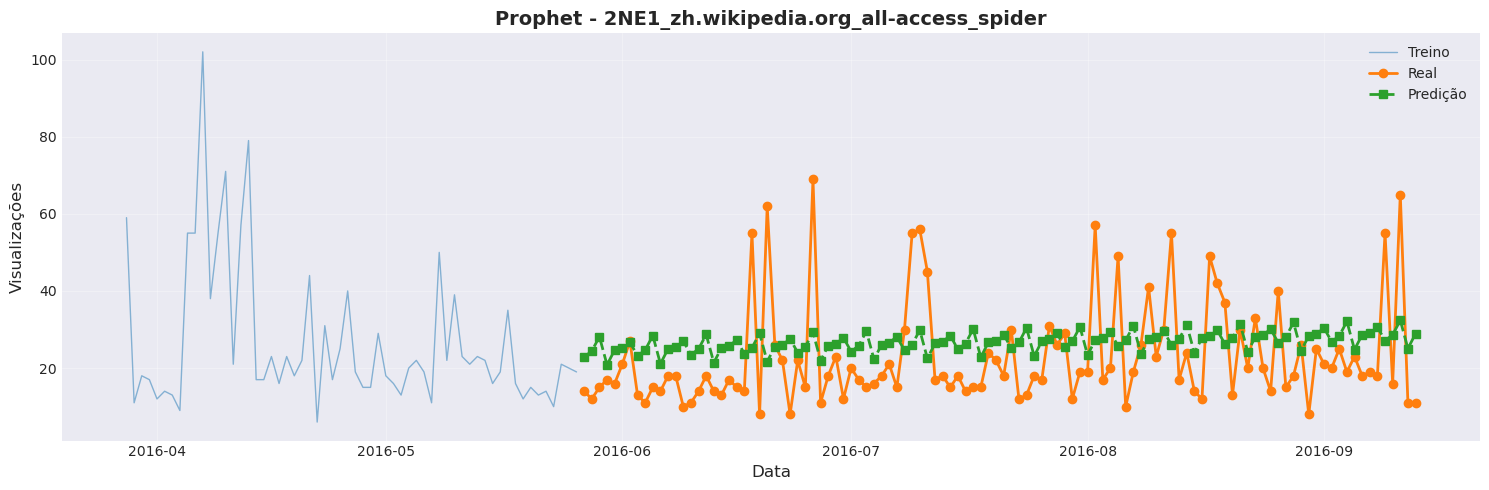

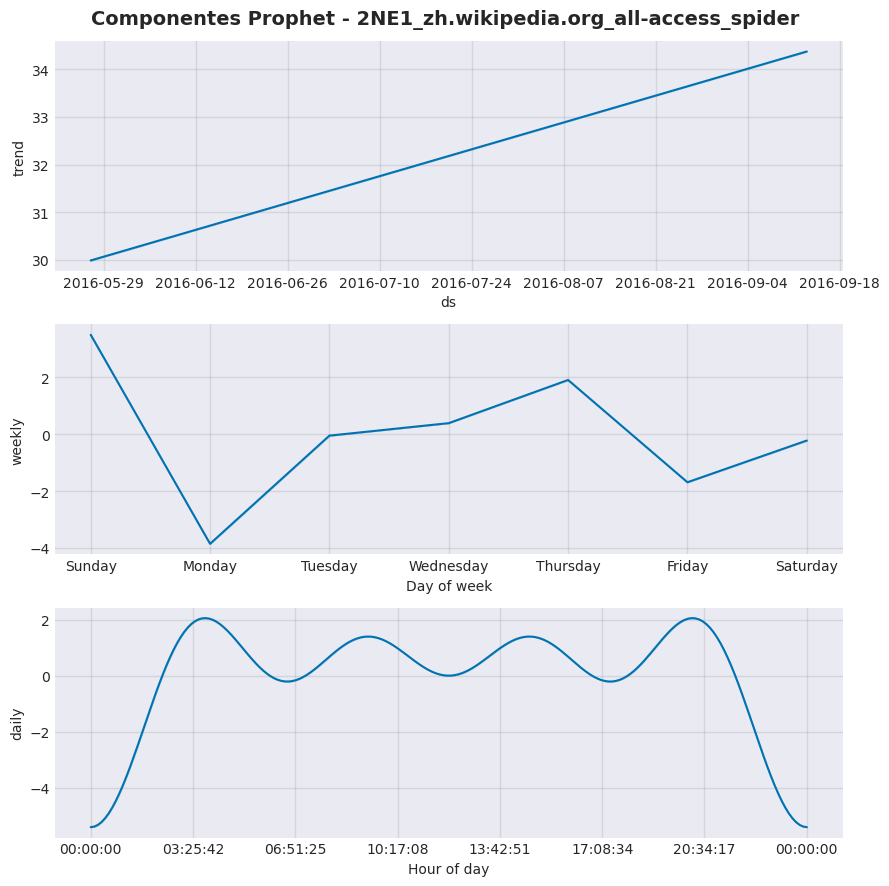

19:58:20 - cmdstanpy - INFO - Chain [1] start processing
19:58:20 - cmdstanpy - INFO - Chain [1] done processing
19:58:20 - cmdstanpy - INFO - Chain [1] start processing
19:58:20 - cmdstanpy - INFO - Chain [1] done processing



Processando: 2PM_zh.wikipedia.org_all-access_spider...

Processando: 3C_zh.wikipedia.org_all-access_spider...

Processando: 4minute_zh.wikipedia.org_all-access_spider...


19:58:20 - cmdstanpy - INFO - Chain [1] start processing
19:58:20 - cmdstanpy - INFO - Chain [1] done processing
19:58:21 - cmdstanpy - INFO - Chain [1] start processing
19:58:21 - cmdstanpy - INFO - Chain [1] done processing
19:58:21 - cmdstanpy - INFO - Chain [1] start processing
19:58:21 - cmdstanpy - INFO - Chain [1] done processing



Processando: 52_Hz_I_Love_You_zh.wikipedia.org_all-access_spide...

Processando: 5566_zh.wikipedia.org_all-access_spider...

Processando: 91Days_zh.wikipedia.org_all-access_spider...


19:58:21 - cmdstanpy - INFO - Chain [1] start processing
19:58:21 - cmdstanpy - INFO - Chain [1] done processing
19:58:21 - cmdstanpy - INFO - Chain [1] start processing
19:58:21 - cmdstanpy - INFO - Chain [1] done processing



Processando: A'N'D_zh.wikipedia.org_all-access_spider...

Processando: AKB48_zh.wikipedia.org_all-access_spider...

RESULTADOS MÉDIOS - PROPHET
MAE     1.246474e+01
RMSE    1.689974e+01
MAPE    3.638082e+10
R²     -3.819401e-01
dtype: float64


In [5]:
print("="*60)
print("PROPHET (FACEBOOK PROPHET)")
print("="*60)

prophet_results = []

for page in train_data['Page'].unique():
    print(f"\nProcessando: {page[:50]}...")
    
    page_train = train_data[train_data['Page'] == page].sort_values('Date')
    page_val = val_data[val_data['Page'] == page].sort_values('Date')
    
    if len(page_val) > 0 and len(page_train) > 14:
        try:
            # Preparar dados para Prophet (requer colunas 'ds' e 'y')
            prophet_train = pd.DataFrame({
                'ds': page_train['Date'],
                'y': page_train['Views']
            })
            
            # Criar e treinar modelo
            model = Prophet(
                daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=False,
                changepoint_prior_scale=0.05,
                seasonality_prior_scale=10.0
            )
            
            model.fit(prophet_train)
            
            # Fazer previsões
            future = pd.DataFrame({'ds': page_val['Date']})
            forecast = model.predict(future)
            prophet_pred = forecast['yhat'].values
            
            # Garantir valores não-negativos
            prophet_pred = np.maximum(prophet_pred, 0)
            
            # Métricas
            metrics = calculate_metrics(page_val['Views'].values, prophet_pred, "Prophet")
            metrics['Page'] = page
            prophet_results.append(metrics)
            
            # Visualizar primeira página
            if page == train_data['Page'].unique()[0]:
                plot_predictions(page_val['Views'].values, prophet_pred, 
                               page_val['Date'].values, 
                               f'Prophet - {page[:40]}',
                               page_train[-60:])
                
                # Plot de componentes do Prophet
                fig = model.plot_components(forecast)
                plt.suptitle(f'Componentes Prophet - {page[:40]}', fontsize=14, fontweight='bold')
                plt.tight_layout()
                plt.show()
        
        except Exception as e:
            print(f"  Erro ao ajustar Prophet: {e}")

# Consolidar resultados
prophet_df = pd.DataFrame(prophet_results)
print("\n" + "="*60)
print("RESULTADOS MÉDIOS - PROPHET")
print("="*60)
print(prophet_df[['MAE', 'RMSE', 'MAPE', 'R²']].mean())

results['Prophet'] = prophet_df

## 2. Regressão com Features Temporais

REGRESSÃO COM FEATURES TEMPORAIS

Usando 26 features:
['Month', 'DayOfWeek', 'Quarter', 'IsWeekend', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'Views_lag_1', 'Views_lag_7'] ...

Treinando: Ridge
Processando: 2NE1_zh.wikipedia.org_all-access_spider... 

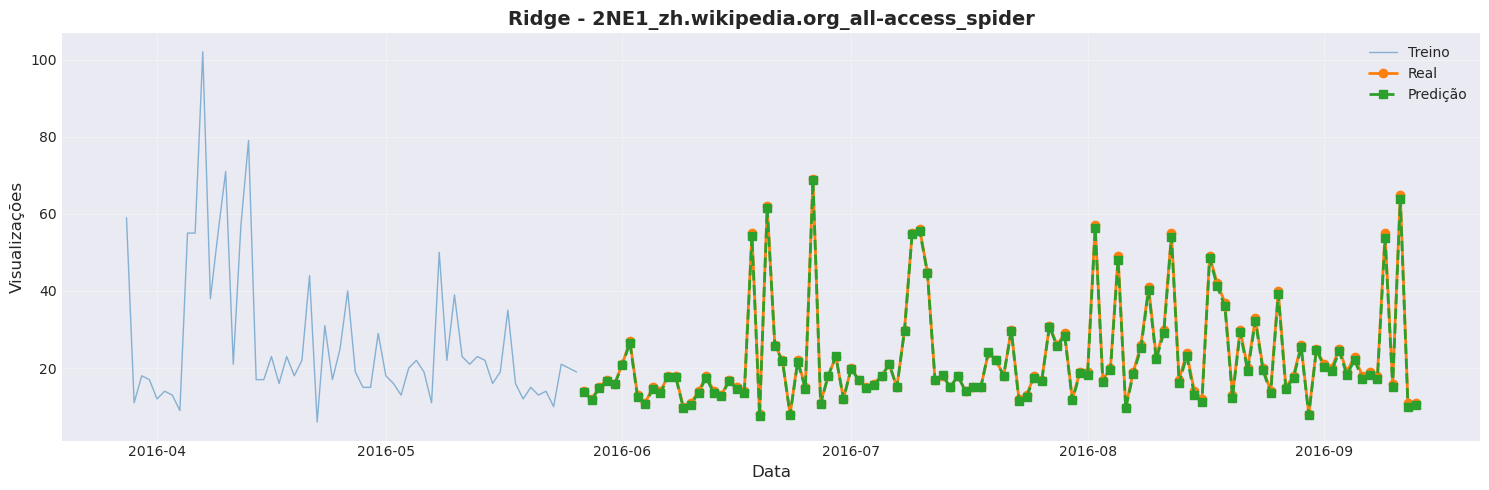

OK
Processando: 2PM_zh.wikipedia.org_all-access_spider... OK
Processando: 3C_zh.wikipedia.org_all-access_spider... OK
Processando: 4minute_zh.wikipedia.org_all-access_spider... OK
Processando: 52_Hz_I_Love_You_zh.wikipedia.org_all-access_spide... OK
Processando: 5566_zh.wikipedia.org_all-access_spider... OK
Processando: 91Days_zh.wikipedia.org_all-access_spider... OK
Processando: A'N'D_zh.wikipedia.org_all-access_spider... OK
Processando: AKB48_zh.wikipedia.org_all-access_spider... OK

Resultados médios - Ridge:
MAE     1.544428e+00
RMSE    2.248995e+00
MAPE    2.846237e+09
R²      8.545870e-01
dtype: float64

Treinando: Random_Forest
Processando: 2NE1_zh.wikipedia.org_all-access_spider... 

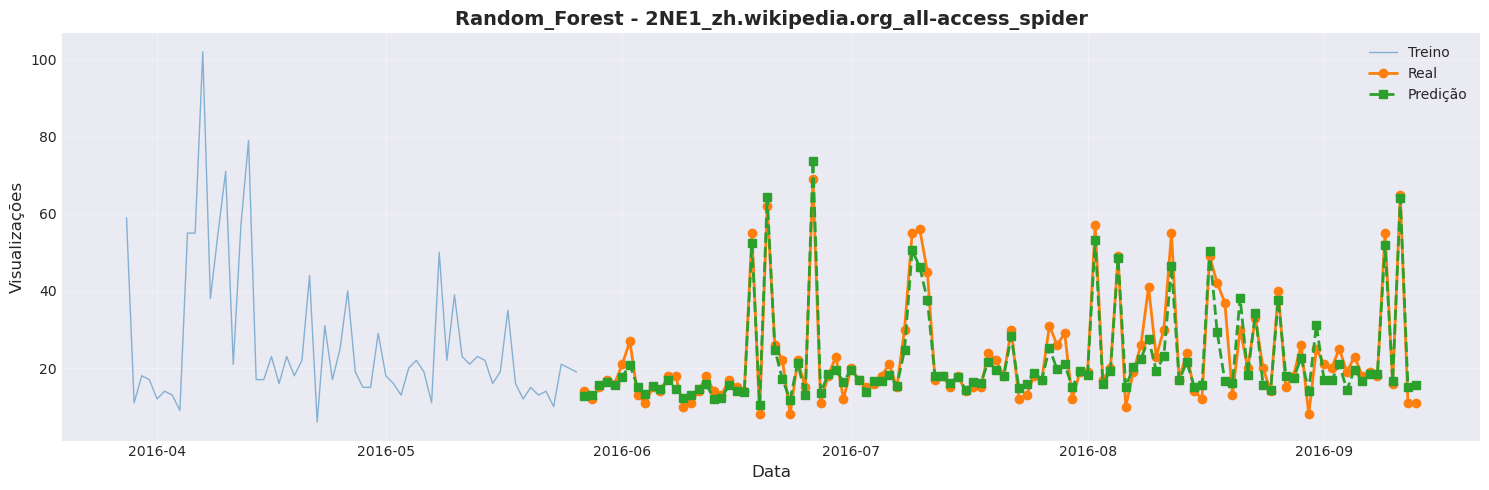

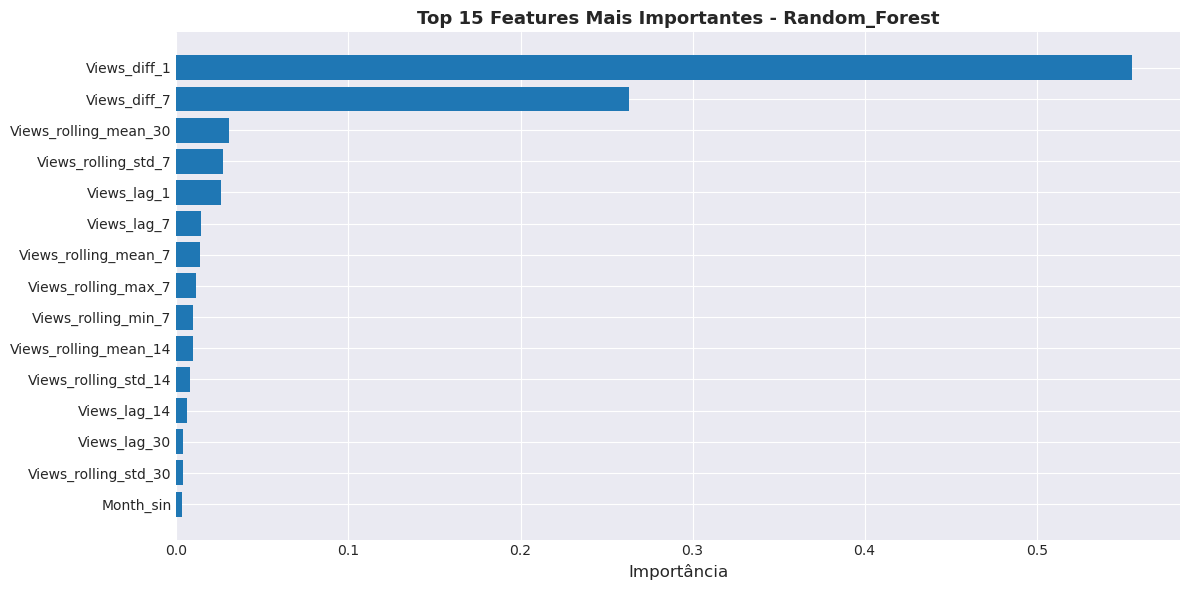

OK
Processando: 2PM_zh.wikipedia.org_all-access_spider... OK
Processando: 3C_zh.wikipedia.org_all-access_spider... OK
Processando: 4minute_zh.wikipedia.org_all-access_spider... OK
Processando: 52_Hz_I_Love_You_zh.wikipedia.org_all-access_spide... OK
Processando: 5566_zh.wikipedia.org_all-access_spider... OK
Processando: 91Days_zh.wikipedia.org_all-access_spider... OK
Processando: A'N'D_zh.wikipedia.org_all-access_spider... OK
Processando: AKB48_zh.wikipedia.org_all-access_spider... OK

Resultados médios - Random_Forest:
MAE     4.460724e+00
RMSE    6.738725e+00
MAPE    1.201085e+10
R²      7.373512e-01
dtype: float64

Treinando: Gradient_Boosting
Processando: 2NE1_zh.wikipedia.org_all-access_spider... 

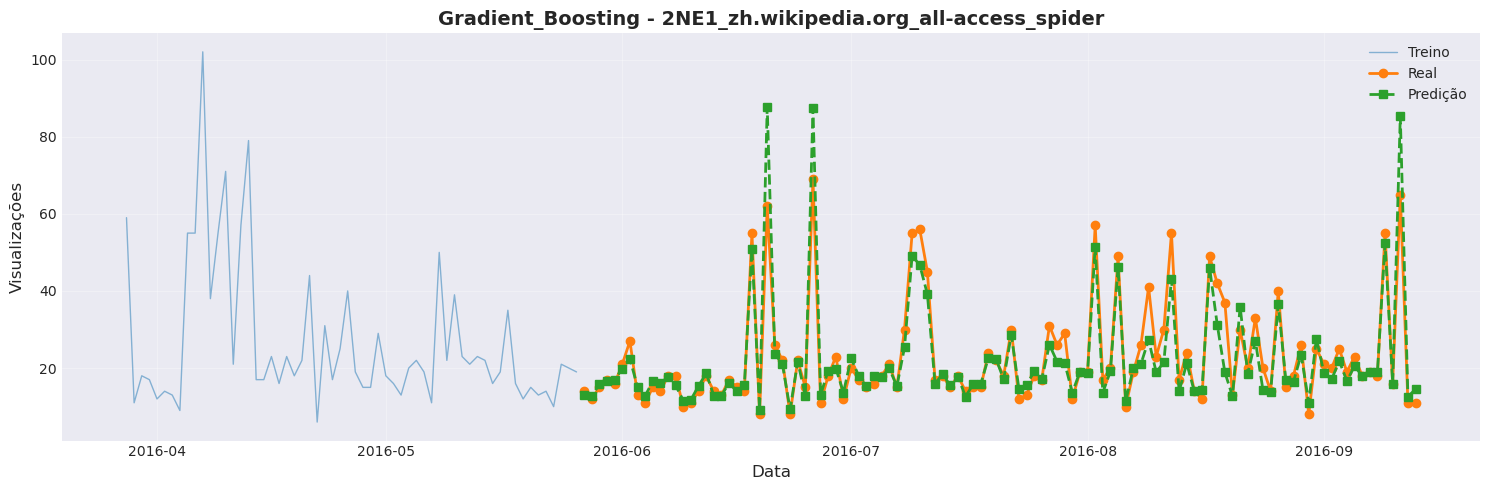

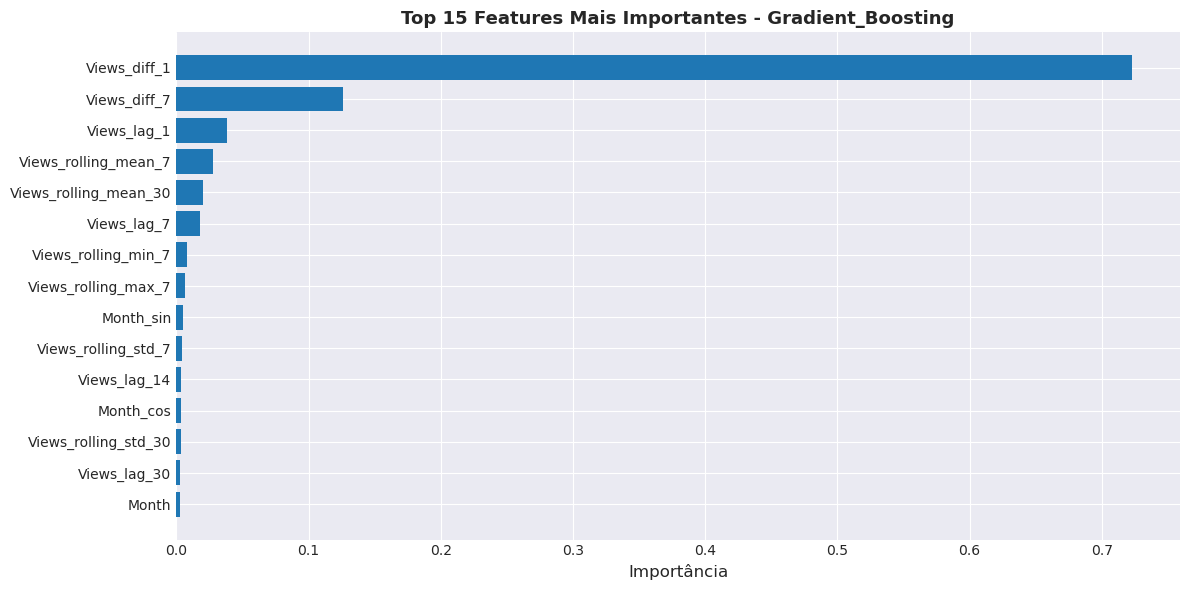

OK
Processando: 2PM_zh.wikipedia.org_all-access_spider... OK
Processando: 3C_zh.wikipedia.org_all-access_spider... OK
Processando: 4minute_zh.wikipedia.org_all-access_spider... OK
Processando: 52_Hz_I_Love_You_zh.wikipedia.org_all-access_spide... OK
Processando: 5566_zh.wikipedia.org_all-access_spider... OK
Processando: 91Days_zh.wikipedia.org_all-access_spider... OK
Processando: A'N'D_zh.wikipedia.org_all-access_spider... OK
Processando: AKB48_zh.wikipedia.org_all-access_spider... OK

Resultados médios - Gradient_Boosting:
MAE     3.780931e+00
RMSE    6.148325e+00
MAPE    8.963672e+09
R²      7.463290e-01
dtype: float64

Treinando: XGBoost
Processando: 2NE1_zh.wikipedia.org_all-access_spider... 

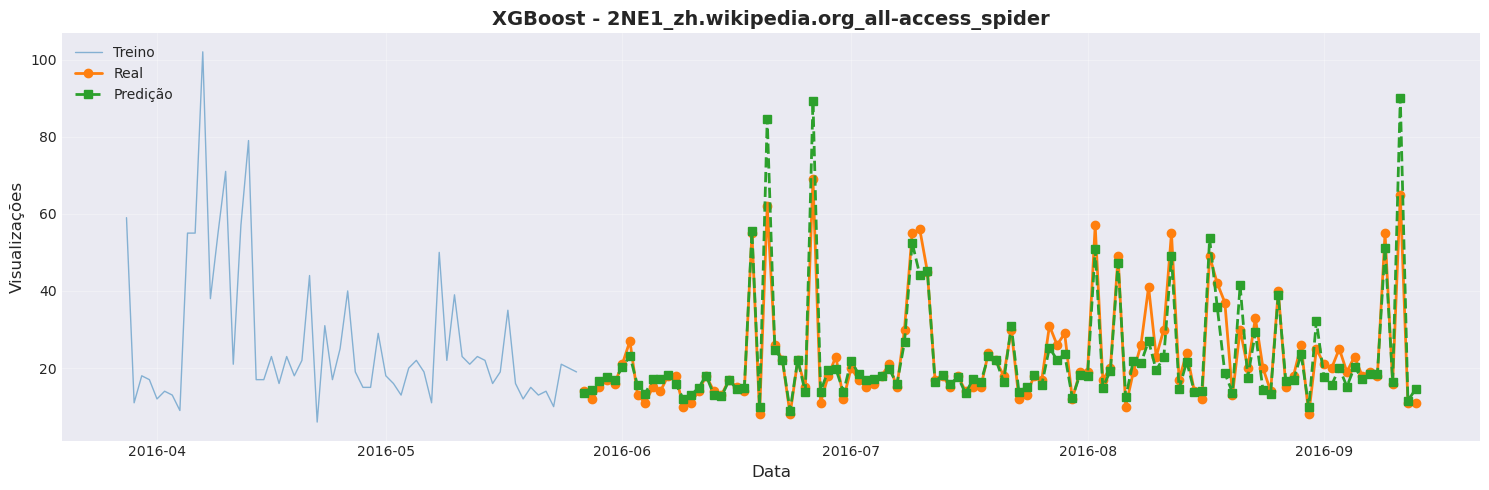

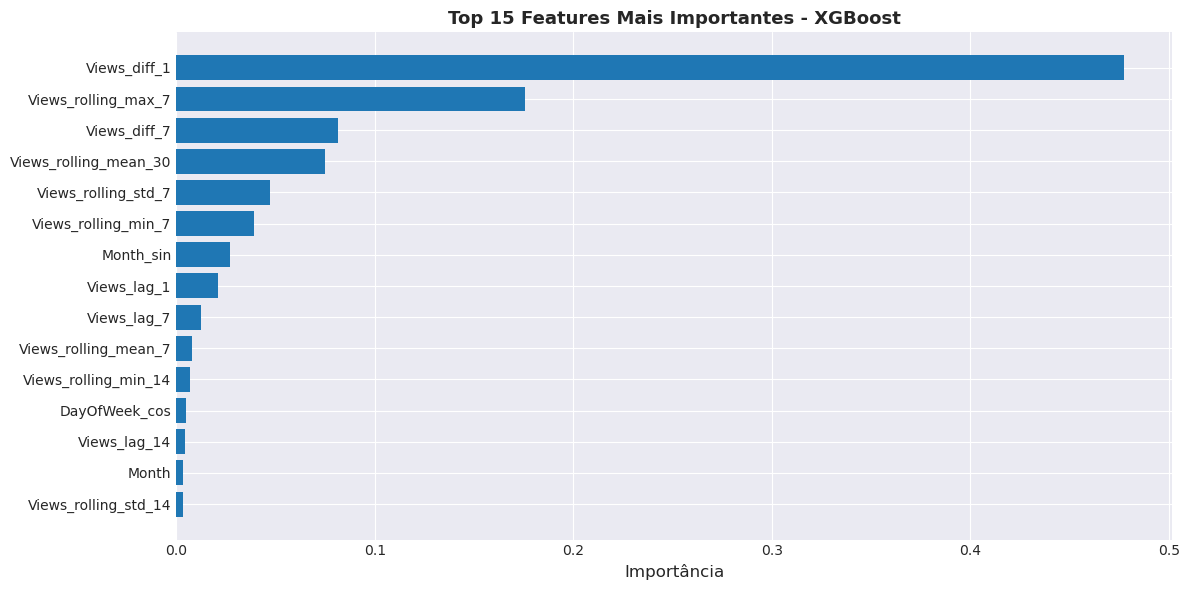

OK
Processando: 2PM_zh.wikipedia.org_all-access_spider... OK
Processando: 3C_zh.wikipedia.org_all-access_spider... OK
Processando: 4minute_zh.wikipedia.org_all-access_spider... OK
Processando: 52_Hz_I_Love_You_zh.wikipedia.org_all-access_spide... OK
Processando: 5566_zh.wikipedia.org_all-access_spider... OK
Processando: 91Days_zh.wikipedia.org_all-access_spider... OK
Processando: A'N'D_zh.wikipedia.org_all-access_spider... OK
Processando: AKB48_zh.wikipedia.org_all-access_spider... OK

Resultados médios - XGBoost:
MAE     3.934768e+00
RMSE    6.179037e+00
MAPE    9.750651e+09
R²      7.471572e-01
dtype: float64


In [6]:
print("="*60)
print("REGRESSÃO COM FEATURES TEMPORAIS")
print("="*60)

# Features para usar
feature_cols = [col for col in train_data.columns if any([
    'lag' in col.lower(),
    'rolling' in col.lower(),
    'diff' in col.lower(),
    col in ['DayOfWeek', 'Month', 'Quarter', 'IsWeekend',
            'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos']
])]

print(f"\nUsando {len(feature_cols)} features:")
print(feature_cols[:10], "...")

# Testar diferentes algoritmos
models_to_test = {
    'Ridge': Ridge(alpha=1.0),
    'Random_Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient_Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
}

regression_results = {}

for model_name, model in models_to_test.items():
    print(f"\n{'='*60}")
    print(f"Treinando: {model_name}")
    print(f"{'='*60}")
    
    model_results = []
    
    for page in train_data['Page'].unique():
        print(f"Processando: {page[:50]}...", end=" ")
        
        page_train = train_data[train_data['Page'] == page].sort_values('Date')
        page_val = val_data[val_data['Page'] == page].sort_values('Date')
        
        if len(page_val) > 0:
            try:
                # Preparar dados
                X_train = page_train[feature_cols].fillna(0)
                y_train = page_train['Views']
                X_val = page_val[feature_cols].fillna(0)
                y_val = page_val['Views']
                
                # Treinar modelo
                model.fit(X_train, y_train)
                
                # Fazer previsões
                pred = model.predict(X_val)
                pred = np.maximum(pred, 0)  # Garantir não-negativos
                
                # Métricas
                metrics = calculate_metrics(y_val.values, pred, model_name)
                metrics['Page'] = page
                model_results.append(metrics)
                
                # Visualizar primeira página
                if page == train_data['Page'].unique()[0]:
                    plot_predictions(y_val.values, pred, 
                                   page_val['Date'].values, 
                                   f'{model_name} - {page[:40]}',
                                   page_train[-60:])
                    
                    # Feature importance (se disponível)
                    if hasattr(model, 'feature_importances_'):
                        importance = pd.DataFrame({
                            'Feature': feature_cols,
                            'Importance': model.feature_importances_
                        }).sort_values('Importance', ascending=False).head(15)
                        
                        plt.figure(figsize=(12, 6))
                        plt.barh(importance['Feature'], importance['Importance'])
                        plt.xlabel('Importância', fontsize=12)
                        plt.title(f'Top 15 Features Mais Importantes - {model_name}', 
                                fontsize=13, fontweight='bold')
                        plt.gca().invert_yaxis()
                        plt.tight_layout()
                        plt.show()
                
                print("OK")
                
            except Exception as e:
                print(f"Erro: {e}")
    
    # Consolidar resultados
    model_df = pd.DataFrame(model_results)
    regression_results[model_name] = model_df
    
    print(f"\nResultados médios - {model_name}:")
    print(model_df[['MAE', 'RMSE', 'MAPE', 'R²']].mean())

# Adicionar ao results
results.update(regression_results)

## 3. LSTM (Long Short-Term Memory)

LSTM (LONG SHORT-TERM MEMORY)

Processando: 2NE1_zh.wikipedia.org_all-access_spider...


2025-11-23 19:58:28.027041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


  Epochs treinados: 45
  MAE final: 11.46


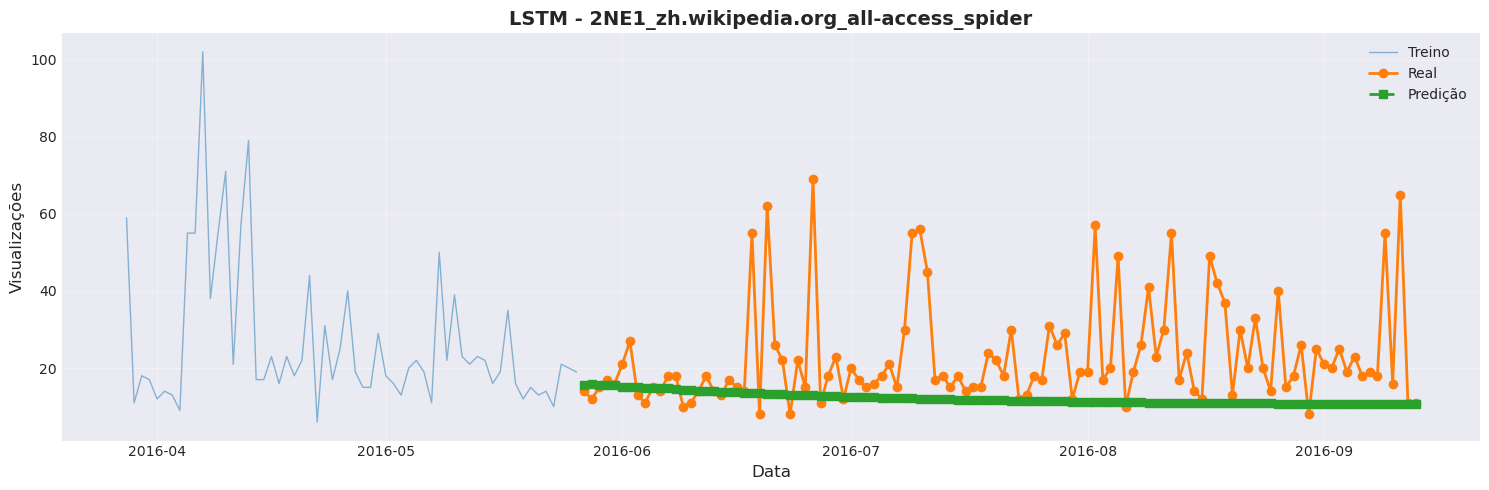

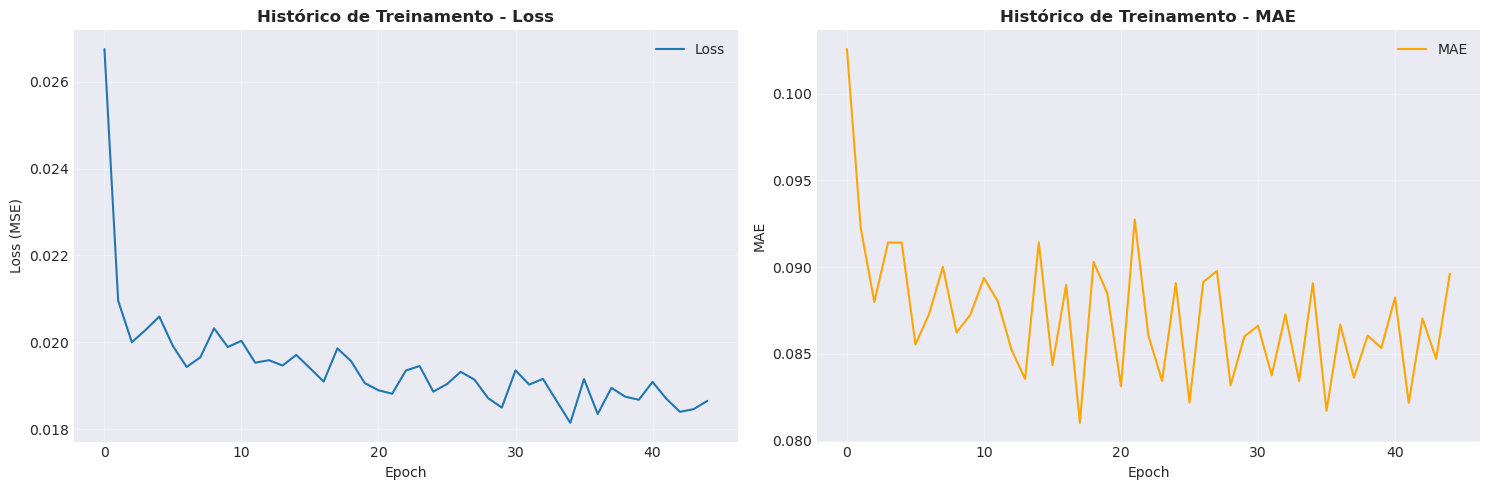


Processando: 2PM_zh.wikipedia.org_all-access_spider...
  Epochs treinados: 50
  MAE final: 11.34

Processando: 3C_zh.wikipedia.org_all-access_spider...
  Epochs treinados: 31
  MAE final: 2.34

Processando: 4minute_zh.wikipedia.org_all-access_spider...
  Epochs treinados: 17
  MAE final: 7.18

Processando: 52_Hz_I_Love_You_zh.wikipedia.org_all-access_spide...
  Epochs treinados: 50
  MAE final: 3.04

Processando: 5566_zh.wikipedia.org_all-access_spider...
  Epochs treinados: 50
  MAE final: 5.06

Processando: 91Days_zh.wikipedia.org_all-access_spider...
  Epochs treinados: 11
  MAE final: 7.73

Processando: A'N'D_zh.wikipedia.org_all-access_spider...
  Epochs treinados: 30
  MAE final: 40.87

Processando: AKB48_zh.wikipedia.org_all-access_spider...
  Epochs treinados: 40
  MAE final: 9.75

RESULTADOS MÉDIOS - LSTM
MAE     1.097327e+01
RMSE    1.620314e+01
MAPE    1.935898e+10
R²     -2.141177e-01
dtype: float64


In [7]:
print("="*60)
print("LSTM (LONG SHORT-TERM MEMORY)")
print("="*60)

def create_sequences(data, n_steps):
    """
    Cria sequências para LSTM
    """
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

lstm_results = []
n_steps = 14  # Usar últimos 14 dias para prever próximo

for page in train_data['Page'].unique():
    print(f"\nProcessando: {page[:50]}...")
    
    page_train = train_data[train_data['Page'] == page].sort_values('Date')
    page_val = val_data[val_data['Page'] == page].sort_values('Date')
    
    if len(page_val) > 0 and len(page_train) > n_steps + 10:
        try:
            # Escalar dados
            scaler = MinMaxScaler()
            train_scaled = scaler.fit_transform(page_train[['Views']])
            
            # Criar sequências
            X_train, y_train = create_sequences(train_scaled.flatten(), n_steps)
            X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
            
            # Criar modelo LSTM
            model = Sequential([
                LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, 1)),
                Dropout(0.2),
                LSTM(50, activation='relu'),
                Dropout(0.2),
                Dense(1)
            ])
            
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])
            
            # Treinar com early stopping
            early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
            
            history = model.fit(
                X_train, y_train,
                epochs=50,
                batch_size=16,
                verbose=0,
                callbacks=[early_stop]
            )
            
            # Fazer previsões iterativas
            predictions = []
            current_sequence = train_scaled[-n_steps:].flatten()
            
            for _ in range(len(page_val)):
                X_input = current_sequence[-n_steps:].reshape((1, n_steps, 1))
                pred = model.predict(X_input, verbose=0)[0, 0]
                predictions.append(pred)
                current_sequence = np.append(current_sequence, pred)
            
            # Inverter escala
            lstm_pred = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
            lstm_pred = np.maximum(lstm_pred, 0)
            
            # Métricas
            metrics = calculate_metrics(page_val['Views'].values, lstm_pred, "LSTM")
            metrics['Page'] = page
            metrics['Epochs'] = len(history.history['loss'])
            lstm_results.append(metrics)
            
            print(f"  Epochs treinados: {len(history.history['loss'])}")
            print(f"  MAE final: {metrics['MAE']:.2f}")
            
            # Visualizar primeira página
            if page == train_data['Page'].unique()[0]:
                plot_predictions(page_val['Views'].values, lstm_pred, 
                               page_val['Date'].values, 
                               f'LSTM - {page[:40]}',
                               page_train[-60:])
                
                # Plot de histórico de treinamento
                fig, axes = plt.subplots(1, 2, figsize=(15, 5))
                
                axes[0].plot(history.history['loss'], label='Loss')
                axes[0].set_title('Histórico de Treinamento - Loss', fontsize=12, fontweight='bold')
                axes[0].set_xlabel('Epoch')
                axes[0].set_ylabel('Loss (MSE)')
                axes[0].legend()
                axes[0].grid(True, alpha=0.3)
                
                axes[1].plot(history.history['mae'], label='MAE', color='orange')
                axes[1].set_title('Histórico de Treinamento - MAE', fontsize=12, fontweight='bold')
                axes[1].set_xlabel('Epoch')
                axes[1].set_ylabel('MAE')
                axes[1].legend()
                axes[1].grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
        
        except Exception as e:
            print(f"  Erro ao treinar LSTM: {e}")

# Consolidar resultados
lstm_df = pd.DataFrame(lstm_results)
print("\n" + "="*60)
print("RESULTADOS MÉDIOS - LSTM")
print("="*60)
print(lstm_df[['MAE', 'RMSE', 'MAPE', 'R²']].mean())

results['LSTM'] = lstm_df

## 4. Comparação de Todos os Modelos

COMPARAÇÃO FINAL DE TODOS OS MODELOS

Métricas médias por modelo (ordenado por MAE):
           Modelo       MAE      RMSE         MAPE        R²
            Ridge  1.544428  2.248995 2.846237e+09  0.854587
Gradient_Boosting  3.780931  6.148325 8.963672e+09  0.746329
          XGBoost  3.934768  6.179037 9.750651e+09  0.747157
    Random_Forest  4.460724  6.738725 1.201085e+10  0.737351
             LSTM 10.973267 16.203141 1.935898e+10 -0.214118
   Moving_Average 11.090323 16.005009          inf -0.220899
              SES 11.471647 16.779681          inf -0.238649
     Holt_Winters 11.636059 16.738424          inf -0.249301
            ARIMA 12.110520 16.866963          inf -0.443092
          Prophet 12.464743 16.899739 3.638082e+10 -0.381940
           SARIMA 13.012264 17.674725          inf -0.606043
            Naive 13.987273 19.039505          inf -0.491287


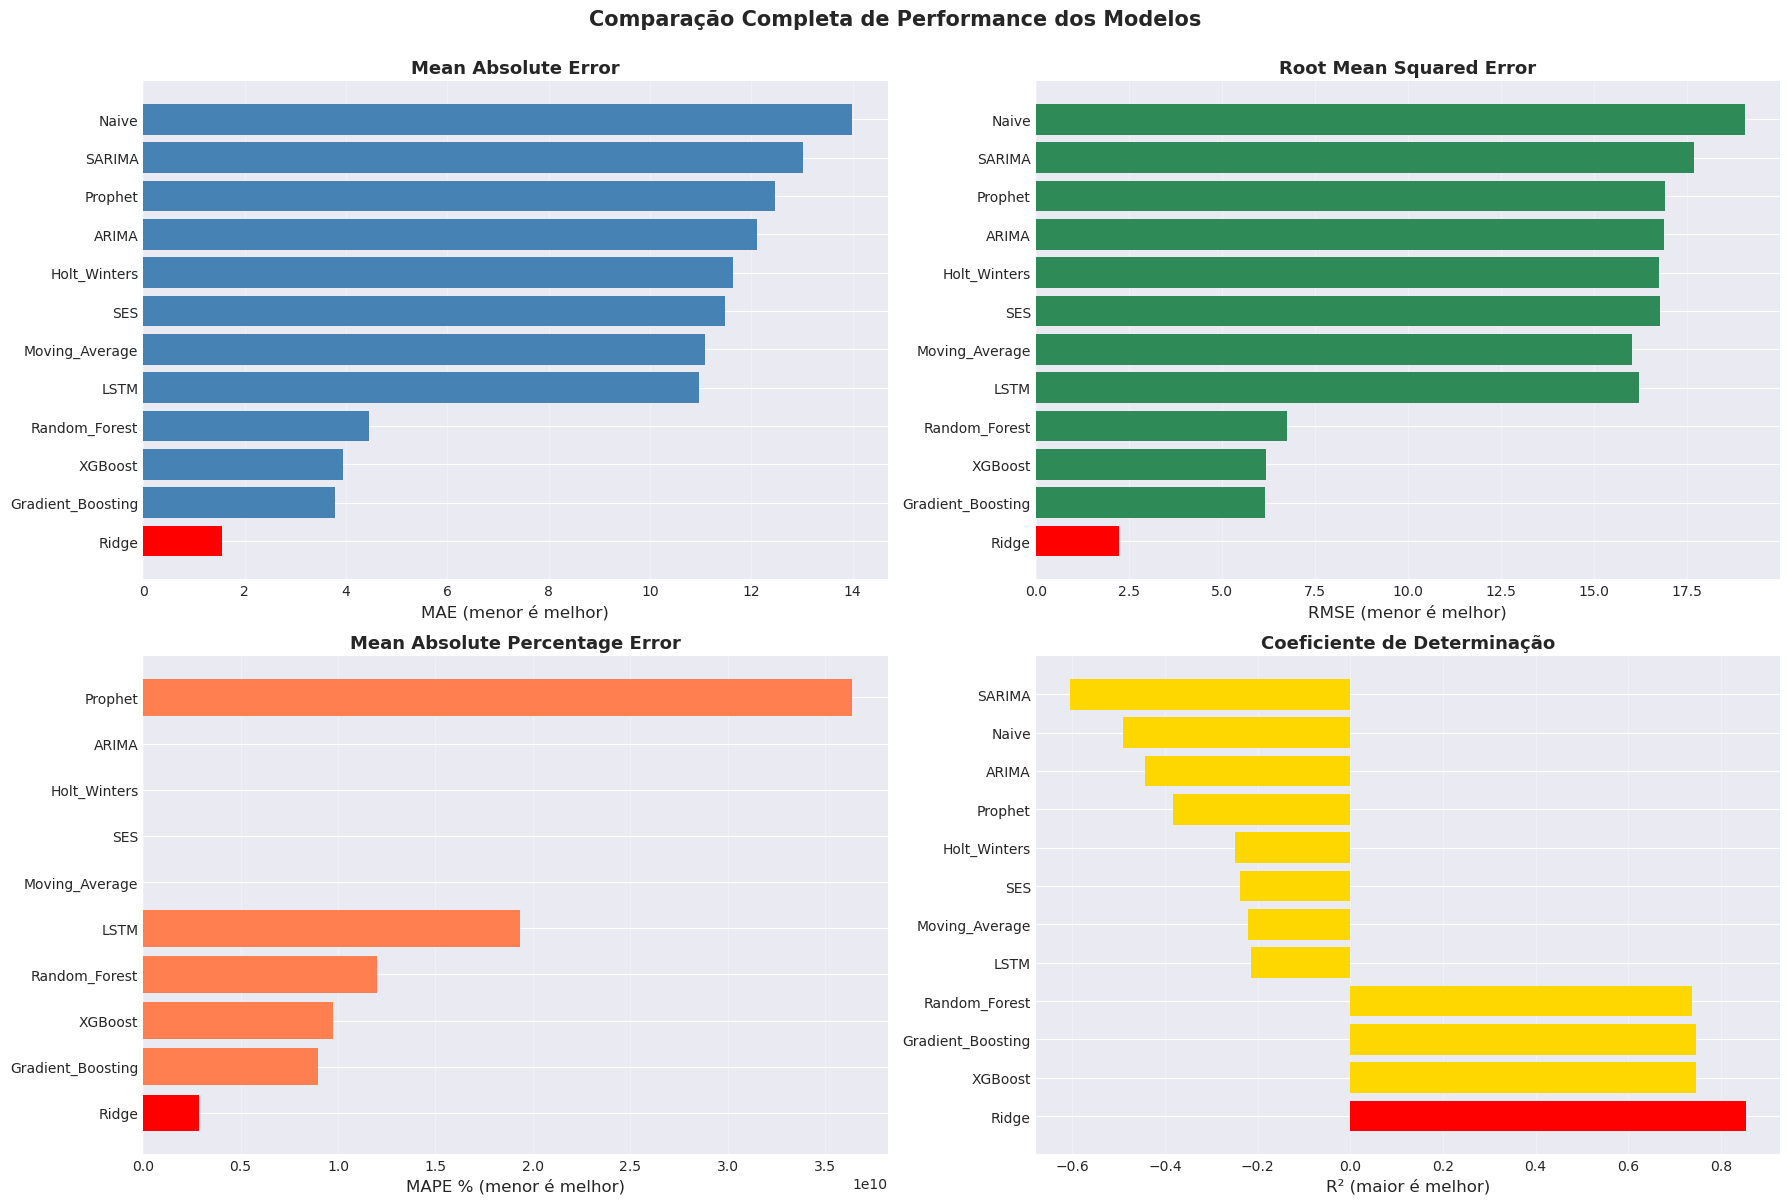


🏆 MELHOR MODELO GERAL: Ridge
  MAE: 1.54
  RMSE: 2.25
  MAPE: 2846237230.58%
  R²: 0.8546


In [8]:
print("="*70)
print("COMPARAÇÃO FINAL DE TODOS OS MODELOS")
print("="*70)

# Combinar resultados anteriores com novos
all_results = {**previous_results, **results}

# Criar dataframe comparativo
comparison_data = []

for model_name, model_df in all_results.items():
    if len(model_df) > 0:
        comparison_data.append({
            'Modelo': model_name,
            'MAE': model_df['MAE'].mean(),
            'RMSE': model_df['RMSE'].mean(),
            'MAPE': model_df['MAPE'].mean(),
            'R²': model_df['R²'].mean()
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('MAE')

print("\nMétricas médias por modelo (ordenado por MAE):")
print(comparison_df.to_string(index=False))

# Visualização comparativa
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# MAE
axes[0, 0].barh(comparison_df['Modelo'], comparison_df['MAE'], 
                color=['red' if i == 0 else 'steelblue' for i in range(len(comparison_df))])
axes[0, 0].set_xlabel('MAE (menor é melhor)', fontsize=12)
axes[0, 0].set_title('Mean Absolute Error', fontsize=13, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# RMSE
axes[0, 1].barh(comparison_df['Modelo'], comparison_df['RMSE'], 
                color=['red' if i == 0 else 'seagreen' for i in range(len(comparison_df))])
axes[0, 1].set_xlabel('RMSE (menor é melhor)', fontsize=12)
axes[0, 1].set_title('Root Mean Squared Error', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# MAPE
axes[1, 0].barh(comparison_df['Modelo'], comparison_df['MAPE'], 
                color=['red' if i == 0 else 'coral' for i in range(len(comparison_df))])
axes[1, 0].set_xlabel('MAPE % (menor é melhor)', fontsize=12)
axes[1, 0].set_title('Mean Absolute Percentage Error', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# R²
comparison_df_sorted_r2 = comparison_df.sort_values('R²', ascending=False)
axes[1, 1].barh(comparison_df_sorted_r2['Modelo'], comparison_df_sorted_r2['R²'], 
                color=['red' if comparison_df_sorted_r2.iloc[i]['Modelo'] == comparison_df.iloc[0]['Modelo'] 
                      else 'gold' for i in range(len(comparison_df_sorted_r2))])
axes[1, 1].set_xlabel('R² (maior é melhor)', fontsize=12)
axes[1, 1].set_title('Coeficiente de Determinação', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.suptitle('Comparação Completa de Performance dos Modelos', 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Identificar melhor modelo
best_model = comparison_df.iloc[0]['Modelo']
best_metrics = comparison_df.iloc[0]

print(f"\n{'='*70}")
print(f"🏆 MELHOR MODELO GERAL: {best_model}")
print(f"{'='*70}")
print(f"  MAE: {best_metrics['MAE']:.2f}")
print(f"  RMSE: {best_metrics['RMSE']:.2f}")
print(f"  MAPE: {best_metrics['MAPE']:.2f}%")
print(f"  R²: {best_metrics['R²']:.4f}")
print(f"{'='*70}")

In [9]:
# Salvar resultados
print("\nSalvando resultados...")

# Salvar comparação final
comparison_df.to_csv('all_models_comparison.csv', index=False)
print("✓ Comparação completa salva: all_models_comparison.csv")

# Salvar todos os resultados
with open('all_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)
print("✓ Todos os resultados salvos: all_results.pkl")

# Salvar melhor modelo
best_model_info = {
    'model_name': best_model,
    'metrics': best_metrics.to_dict()
}

import json
with open('best_model.json', 'w') as f:
    json.dump(best_model_info, f, indent=2)
print("✓ Informações do melhor modelo salvas: best_model.json")

print("\n✓ Modelagem de Machine Learning concluída!")
print("\nPróximo passo: Notebook 05 - Avaliação Final e Comparação")


Salvando resultados...
✓ Comparação completa salva: all_models_comparison.csv
✓ Todos os resultados salvos: all_results.pkl
✓ Informações do melhor modelo salvas: best_model.json

✓ Modelagem de Machine Learning concluída!

Próximo passo: Notebook 05 - Avaliação Final e Comparação
